# Workflow Example with E-OBS input convertor
Here we illustrate a complete workflow example using the E-OBS convertor

## Imports

In [7]:
from pathlib import Path

import xarray as xr
import pandas as pd
from datatree import DataTree

import valenspy as vp #The Valenspy package
from valenspy.inputconverter_functions import _non_convertor

ModuleNotFoundError: No module named 'valenspy'

# Input Convertors

Input convertors are used to convert the data to CF format.
There main component is a function that takes the file and returns the data CF convention.
See input_convertors_functions.py for examples.

The Input convertor is a class that does the following:
- Convert the data
- Check if the converted data meets the CF convention
- ...

In [ ]:
#Import Converter - This input converter will not do anything to the data.
ic = vp.InputConverter(_non_convertor)

## Preparation
Before loading the datasets, the user chooses a variable of interest for which she/he will load the observations. This variable needs to be defined in CF terms using the CORDEX nomenclature. 

In [2]:
# for info, this is the CORDEX variables list, their definitions and additional info. 

# get the lookup tables of CORDEX variables
df_variables_def   = pd.read_csv('../ancilliary_data/CORDEX_variable_requirement_table.csv', sep=";", header=2)
df_variables_def

NameError: name 'pd' is not defined

In [5]:
# User defined variable, here we look at 2m temperature. 
variable = 'tas'

## Loading datasets
Load the data and convert to CF format if necessary.

In this illustration we will load EOBS data (the ensemble mean of 0.1° data) using the added functionality

In [8]:
# define observational paths -- to do: update this to a seperate settings file?  
EOBS_data_dir = Path("/dodrio/scratch/projects/2022_200/project_input/External/observations/EOBS/0.1deg/")

df_lookup_EOBS = pd.read_csv('../ancilliary_data/lookuptable_EOBS.csv', sep=";")

# get E-OBS variable corresponding to the requested variable using its look-up table
EOBS_variable = df_lookup_EOBS.loc[df_lookup_EOBS['variable_name'] == variable,'EOBS_name'].values[0]

# open the EOBS file for the corresponding variable
EOBS_files = list(EOBS_data_dir.glob("*"+EOBS_variable+"*mean*.nc")) #Select all the netCDF files in the directory

EOBS_ds = xr.open_mfdataset(EOBS_files, combine='by_coords', chunks='auto')

# make EOBS CF compliant (and CMORized)
EOBS_ds = EOBS_ds.rename_vars({EOBS_variable: variable})
EOBS_ds = EOBS_ds.rename({"latitude": "lat", "longitude": "lon"})

# Convert from Celsius to Kelvin -- to do: put this in a seperate convertor to be used by other functions? 
if variable == 'tas': 
    EOBS_ds[variable] = EOBS_ds[variable] + 273.15

# add necessary metadata -- this makes the person including the obs data think whether additional processing is needed 

EOBS_ds.attrs["long_name"] = df_variables_meta.loc[df_variables_meta['variable_name'] == variable,'long_name'].values[0] # from the CORDEX look-up table
EOBS_ds.attrs["original_name"] = EOBS_variable
EOBS_ds.attrs["original_long_name"] = df_lookup_EOBS.loc[df_lookup_EOBS['variable_name'] == variable,'EOBS_long_name'].values[0]
EOBS_ds.attrs["units"] = "K" 
EOBS_ds.attrs["time_freq"] = "daily"  # possible values: daily, hourly, monthly, yearly
EOBS_ds.attrs["spatial_resolution"] = "0.1deg"  
EOBS_ds.attrs["domain"] = "europe"


EOBS_ds

ValueError: unrecognized chunk manager dask - must be one of: []

In [ ]:
#Observational dataset
EOBS_data_dir = Path("/dodrio/scratch/projects/2022_200/project_input/External/observations/EOBS/0.1deg/")

EOBS_obs_files = list(EOBS_data_dir.glob("*tg*mean*.nc")) #Select all the netCDF files in the directory
EOBS_obs_files = ic.convert_input(EOBS_obs_files) #Convert the input to the correct format

EOBS_ds = xr.open_mfdataset(EOBS_obs_files, combine='by_coords', chunks='auto')

#THIS SHOULD ALL BE IN THE INPUT CONVERTER FOR THE DATASET
EOBS_ds = EOBS_ds.rename_vars({"tg": "tas"})
EOBS_ds = EOBS_ds.rename({"latitude": "lat", "longitude": "lon"})
#Convert from Celsius to Kelvin
EOBS_ds["tas"] = EOBS_ds["tas"] + 273.15

#Select a small region covering Belgium for testing
EOBS_ds = EOBS_ds.sel(time=slice("1953-01-01", "1954-12-31"))
EOBS_ds = EOBS_ds.sel(lat=slice(49, 51), lon=slice(3, 5))

EOBS_ds

<xarray.Dataset> Size: 1MB
Dimensions:  (lat: 20, lon: 20, time: 730)
Coordinates:
  * lat      (lat) float64 160B 49.05 49.15 49.25 49.35 ... 50.75 50.85 50.95
  * lon      (lon) float64 160B 3.05 3.15 3.25 3.35 3.45 ... 4.65 4.75 4.85 4.95
  * time     (time) datetime64[ns] 6kB 1953-01-01 1953-01-02 ... 1954-12-31
Data variables:
    tas      (time, lat, lon) float32 1MB dask.array<chunksize=(26, 20, 20), meta=np.ndarray>
Attributes:
    E-OBS_version:  29.0e
    Conventions:    CF-1.4
    References:     http://surfobs.climate.copernicus.eu/dataaccess/access_eo...
    history:        Fri Mar 22 09:55:59 2024: ncks --no-abc -d time,0,27027 /...
    NCO:            netCDF Operators version 5.1.4 (Homepage = http://nco.sf....

In [4]:
#CMIP6 dataset
#Now make an ensemble member object
EC_Earth3_dir = Path("/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc46032_kobe/ValEnsPy/tests/data")
EC_Earth3_hist_files = list(EC_Earth3_dir.glob("*historical*.nc")) #Select all the netCDF files in the directory
EC_Earth3_hist_files = ic.convert_input(EC_Earth3_hist_files) #Convert the input to the correct format
EC_Earth3_ds = xr.open_mfdataset(EC_Earth3_hist_files, combine='by_coords', chunks='auto')
EC_Earth3_ds

<xarray.Dataset> Size: 13MB
Dimensions:    (time: 24, bnds: 2, lat: 256, lon: 512)
Coordinates:
  * time       (time) datetime64[ns] 192B 1953-01-16T12:00:00 ... 1954-12-16T...
  * lat        (lat) float64 2kB -89.46 -88.77 -88.07 ... 88.07 88.77 89.46
  * lon        (lon) float64 4kB 0.0 0.7031 1.406 2.109 ... 357.9 358.6 359.3
    height     float64 8B 2.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] 384B dask.array<chunksize=(12, 2), meta=np.ndarray>
    lat_bnds   (time, lat, bnds) float64 98kB dask.array<chunksize=(12, 256, 2), meta=np.ndarray>
    lon_bnds   (time, lon, bnds) float64 197kB dask.array<chunksize=(12, 512, 2), meta=np.ndarray>
    tas        (time, lat, lon) float32 13MB dask.array<chunksize=(12, 256, 512), meta=np.ndarray>
Attributes: (12/46)
    Conventions:                        CF-1.7 CMIP-6.2
    activity_id:                        CMIP
    branch_method:                      standard
    branch_time_in_child:               0.0
    branch_time_in_parent:              29219.0
    contact:                            cmip6-data@ec-earth.org
    ...                                 ...
    variant_label:                      r1i1p1f1
    license:                            CMIP6 model data produced by EC-Earth...
    cmor_version:                       3.4.0
    tracking_id:                        hdl:21.14100/18af2970-6a17-45fe-b629-...
    history:                            2019-06-06T07:27:13Z ; CMOR rewrote d...
    latest_applied_cmor_fixer_version:  v3.0

In [5]:
#Now make an "future" ensemble member object
EC_Earth3_ssp_files = list(EC_Earth3_dir.glob("*ssp245*.nc")) #Select all the netCDF files in the directory
EC_Earth3_ssp_files = ic.convert_input(EC_Earth3_ssp_files) #Convert the input to the correct format
EC_Earth3_ssp_ds = xr.open_mfdataset(EC_Earth3_ssp_files, combine='by_coords', chunks='auto')
EC_Earth3_ssp_ds

<xarray.Dataset> Size: 13MB
Dimensions:    (time: 24, bnds: 2, lat: 256, lon: 512)
Coordinates:
  * time       (time) datetime64[ns] 192B 2015-01-16T12:00:00 ... 2016-12-16T...
  * lat        (lat) float64 2kB -89.46 -88.77 -88.07 ... 88.07 88.77 89.46
  * lon        (lon) float64 4kB 0.0 0.7031 1.406 2.109 ... 357.9 358.6 359.3
    height     float64 8B 2.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] 384B dask.array<chunksize=(12, 2), meta=np.ndarray>
    lat_bnds   (time, lat, bnds) float64 98kB dask.array<chunksize=(12, 256, 2), meta=np.ndarray>
    lon_bnds   (time, lon, bnds) float64 197kB dask.array<chunksize=(12, 512, 2), meta=np.ndarray>
    tas        (time, lat, lon) float32 13MB dask.array<chunksize=(12, 256, 512), meta=np.ndarray>
Attributes: (12/45)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   60265.0
    branch_time_in_parent:  60265.0
    contact:                cmip6-data@ec-earth.org
    ...                     ...
    variable_id:            tas
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by EC-Earth-Consortium ...
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/697b3a82-4ffc-49ce-b070-2ca86ce8a06f
    history:                2019-06-29T08:25:09Z ; CMOR rewrote data to be co...

## DataTree

The DataTree structures the data.
This will be very useful for the preprocessing and the diagnostics.

In [6]:
dt = DataTree.from_dict({"obs/EOBS": EOBS_ds, "ensembles/cmip6/EC_Earth3/hist": EC_Earth3_ds, "ensembles/cmip6/EC_Earth3/ssp245": EC_Earth3_ssp_ds})
dt

DataTree('None', parent=None)
├── DataTree('obs')
│   └── DataTree('EOBS')
│           Dimensions:  (lat: 20, lon: 20, time: 730)
│           Coordinates:
│             * lat      (lat) float64 160B 49.05 49.15 49.25 49.35 ... 50.75 50.85 50.95
│             * lon      (lon) float64 160B 3.05 3.15 3.25 3.35 3.45 ... 4.65 4.75 4.85 4.95
│             * time     (time) datetime64[ns] 6kB 1953-01-01 1953-01-02 ... 1954-12-31
│           Data variables:
│               tas      (time, lat, lon) float32 1MB dask.array<chunksize=(26, 20, 20), meta=np.ndarray>
│           Attributes:
│               E-OBS_version:  29.0e
│               Conventions:    CF-1.4
│               References:     http://surfobs.climate.copernicus.eu/dataaccess/access_eo...
│               history:        Fri Mar 22 09:55:59 2024: ncks --no-abc -d time,0,27027 /...
│               NCO:            netCDF Operators version 5.1.4 (Homepage = http://nco.sf....
└── DataTree('ensembles')
    └── DataTree('cmip6')
        └── DataTree('EC_Earth3')
            ├── DataTree('hist')
            │       Dimensions:    (time: 24, bnds: 2, lat: 256, lon: 512)
            │       Coordinates:
            │         * time       (time) datetime64[ns] 192B 1953-01-16T12:00:00 ... 1954-12-16T...
            │         * lat        (lat) float64 2kB -89.46 -88.77 -88.07 ... 88.07 88.77 89.46
            │         * lon        (lon) float64 4kB 0.0 0.7031 1.406 2.109 ... 357.9 358.6 359.3
            │           height     float64 8B 2.0
            │       Dimensions without coordinates: bnds
            │       Data variables:
            │           time_bnds  (time, bnds) datetime64[ns] 384B dask.array<chunksize=(12, 2), meta=np.ndarray>
            │           lat_bnds   (time, lat, bnds) float64 98kB dask.array<chunksize=(12, 256, 2), meta=np.ndarray>
            │           lon_bnds   (time, lon, bnds) float64 197kB dask.array<chunksize=(12, 512, 2), meta=np.ndarray>
            │           tas        (time, lat, lon) float32 13MB dask.array<chunksize=(12, 256, 512), meta=np.ndarray>
            │       Attributes: (12/46)
            │           Conventions:                        CF-1.7 CMIP-6.2
            │           activity_id:                        CMIP
            │           branch_method:                      standard
            │           branch_time_in_child:               0.0
            │           branch_time_in_parent:              29219.0
            │           contact:                            cmip6-data@ec-earth.org
            │           ...                                 ...
            │           variant_label:                      r1i1p1f1
            │           license:                            CMIP6 model data produced by EC-Earth...
            │           cmor_version:                       3.4.0
            │           tracking_id:                        hdl:21.14100/18af2970-6a17-45fe-b629-...
            │           history:                            2019-06-06T07:27:13Z ; CMOR rewrote d...
            │           latest_applied_cmor_fixer_version:  v3.0
            └── DataTree('ssp245')
                    Dimensions:    (time: 24, bnds: 2, lat: 256, lon: 512)
                    Coordinates:
                      * time       (time) datetime64[ns] 192B 2015-01-16T12:00:00 ... 2016-12-16T...
                      * lat        (lat) float64 2kB -89.46 -88.77 -88.07 ... 88.07 88.77 89.46
                      * lon        (lon) float64 4kB 0.0 0.7031 1.406 2.109 ... 357.9 358.6 359.3
                        height     float64 8B 2.0
                    Dimensions without coordinates: bnds
                    Data variables:
                        time_bnds  (time, bnds) datetime64[ns] 384B dask.array<chunksize=(12, 2), meta=np.ndarray>
                        lat_bnds   (time, lat, bnds) float64 98kB dask.array<chunksize=(12, 256, 2), meta=np.ndarray>
                        lon_bnds   (time, lon, bnds) float64 197kB dask.array

## Preprocessing

Define and add preprocessing steps to a preprocessor. These can then be applied to the whole or part of the DataTree.

Here we define a regridding step and select a region.

In [7]:
#Apply some postprocessing operations on the datatree
pp = vp.Preprocessor()
pp.add_preprocessing_task(vp.preprocessing_tasks.Regrid(dt.obs.EOBS.ds, name="to_obs", description="Regrid the CMIP6 data to the EOBS grid"))
pp.add_preprocessing_task(vp.preprocessing_tasks.Set_Domain(dt.obs.EOBS.ds, name="to_obs", description="Select the common area of the EOBS grid"))

### Applying the preprocessing tasks
The preprocessing tasks can be applied on all models in an ensemble in the datatree.
In this example we will apply the regridding and region selection to the CMIP6 data (EC-Earth3 - historical and ssp245).

In [8]:
dt.ensembles = pp.apply_preprocessing(dt.ensembles)

dt

DataTree('None', parent=None)
├── DataTree('obs')
│   └── DataTree('EOBS')
│           Dimensions:  (lat: 20, lon: 20, time: 730)
│           Coordinates:
│             * lat      (lat) float64 160B 49.05 49.15 49.25 49.35 ... 50.75 50.85 50.95
│             * lon      (lon) float64 160B 3.05 3.15 3.25 3.35 3.45 ... 4.65 4.75 4.85 4.95
│             * time     (time) datetime64[ns] 6kB 1953-01-01 1953-01-02 ... 1954-12-31
│           Data variables:
│               tas      (time, lat, lon) float32 1MB dask.array<chunksize=(26, 20, 20), meta=np.ndarray>
│           Attributes:
│               E-OBS_version:  29.0e
│               Conventions:    CF-1.4
│               References:     http://surfobs.climate.copernicus.eu/dataaccess/access_eo...
│               history:        Fri Mar 22 09:55:59 2024: ncks --no-abc -d time,0,27027 /...
│               NCO:            netCDF Operators version 5.1.4 (Homepage = http://nco.sf....
└── DataTree('ensembles')
    └── DataTree('cmip6')
        └── DataTree('EC_Earth3')
            ├── DataTree('hist')
            │       Dimensions:    (time: 24, bnds: 2, lat: 256, lon: 512)
            │       Coordinates:
            │         * time       (time) datetime64[ns] 192B 1953-01-16T12:00:00 ... 1954-12-16T...
            │         * lat        (lat) float64 2kB -89.46 -88.77 -88.07 ... 88.07 88.77 89.46
            │         * lon        (lon) float64 4kB 0.0 0.7031 1.406 2.109 ... 357.9 358.6 359.3
            │           height     float64 8B 2.0
            │       Dimensions without coordinates: bnds
            │       Data variables:
            │           time_bnds  (time, bnds) datetime64[ns] 384B dask.array<chunksize=(12, 2), meta=np.ndarray>
            │           lat_bnds   (time, lat, bnds) float64 98kB dask.array<chunksize=(12, 256, 2), meta=np.ndarray>
            │           lon_bnds   (time, lon, bnds) float64 197kB dask.array<chunksize=(12, 512, 2), meta=np.ndarray>
            │           tas        (time, lat, lon) float32 13MB dask.array<chunksize=(12, 256, 512), meta=np.ndarray>
            │       Attributes: (12/46)
            │           Conventions:                        CF-1.7 CMIP-6.2
            │           activity_id:                        CMIP
            │           branch_method:                      standard
            │           branch_time_in_child:               0.0
            │           branch_time_in_parent:              29219.0
            │           contact:                            cmip6-data@ec-earth.org
            │           ...                                 ...
            │           variant_label:                      r1i1p1f1
            │           license:                            CMIP6 model data produced by EC-Earth...
            │           cmor_version:                       3.4.0
            │           tracking_id:                        hdl:21.14100/18af2970-6a17-45fe-b629-...
            │           history:                            2019-06-06T07:27:13Z ; CMOR rewrote d...
            │           latest_applied_cmor_fixer_version:  v3.0
            └── DataTree('ssp245')
                    Dimensions:    (time: 24, bnds: 2, lat: 256, lon: 512)
                    Coordinates:
                      * time       (time) datetime64[ns] 192B 2015-01-16T12:00:00 ... 2016-12-16T...
                      * lat        (lat) float64 2kB -89.46 -88.77 -88.07 ... 88.07 88.77 89.46
                      * lon        (lon) float64 4kB 0.0 0.7031 1.406 2.109 ... 357.9 358.6 359.3
                        height     float64 8B 2.0
                    Dimensions without coordinates: bnds
                    Data variables:
                        time_bnds  (time, bnds) datetime64[ns] 384B dask.array<chunksize=(12, 2), meta=np.ndarray>
                        lat_bnds   (time, lat, bnds) float64 98kB dask.array<chunksize=(12, 256, 2), meta=np.ndarray>
                        lon_bnds   (time, lon, bnds) float64 197kB dask.array

# Diagnostics
Finally we will make a diagnostic (validation/evaluation) which takes the processed data and compares them.
There are different types of comparisons, here we will use a Model2Ref comparison which compares the model data to the reference dataset.

## Diagnostic object
The diagnostic object consists of the following components:
- A name
- A description
- A function that takes the processed data and returns the results
- A function that takes the results and returns a plot

Common standard diagnostics are (will be) predefined in package.
The users can define there own diagnostic functions and visualizations functions thus creating there own diagnostics.

In [9]:
#Apply a diagnostic operation
#First make a diagnostic object
from valenspy.diagnostic_functions import spatial_bias
from valenspy.diagnostic_visualizations import plot_spatial_bias   

diag = vp.Model2Ref(spatial_bias, plot_spatial_bias, name="spatial_bias", description="Calculate the time averaged spatial bias between the model and the observations")

#Apply the diagnostic
ds = diag.apply(dt.ensembles.cmip6.EC_Earth3.hist, dt.obs.EOBS)
ds

<xarray.DataArray 'tas' (lat: 20, lon: 20)> Size: 2kB
dask.array<sub, shape=(20, 20), dtype=float32, chunksize=(20, 20), chunktype=numpy.ndarray>
Coordinates:
    height   float64 8B 2.0
  * lon      (lon) float64 160B 3.05 3.15 3.25 3.35 3.45 ... 4.65 4.75 4.85 4.95
  * lat      (lat) float64 160B 49.05 49.15 49.25 49.35 ... 50.75 50.85 50.95

As we are using dask the resulting data needs to be computed. 
Note that when plotting, the data is automatically computed.

In [10]:
from dask.diagnostics import ProgressBar
with ProgressBar():
    ds.compute()

[########################################] | 100% Completed | 13.04 ss


### Plotting
Finaly the diagnostic has some built in plotting functionality to visualize the results.
The user can tweek the visualization or make his own starting from the resulting ds.

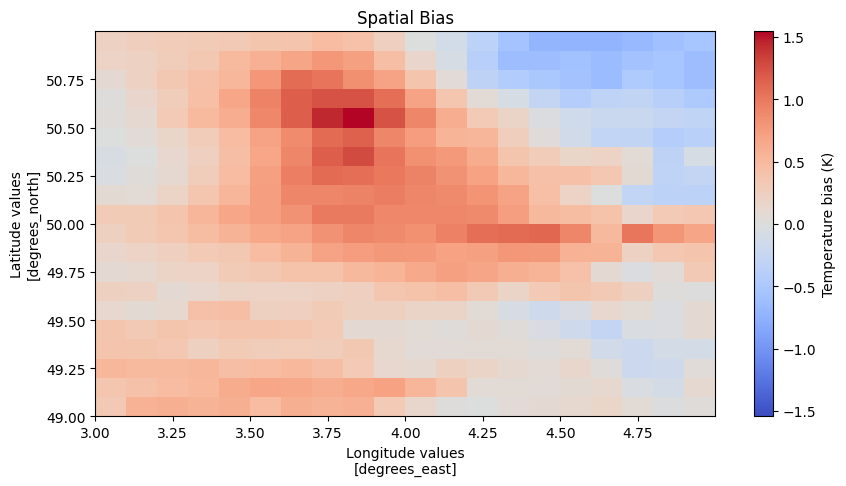

In [11]:
f = diag.visualize(dt.ensembles.cmip6.EC_Earth3.hist, dt.obs.EOBS)

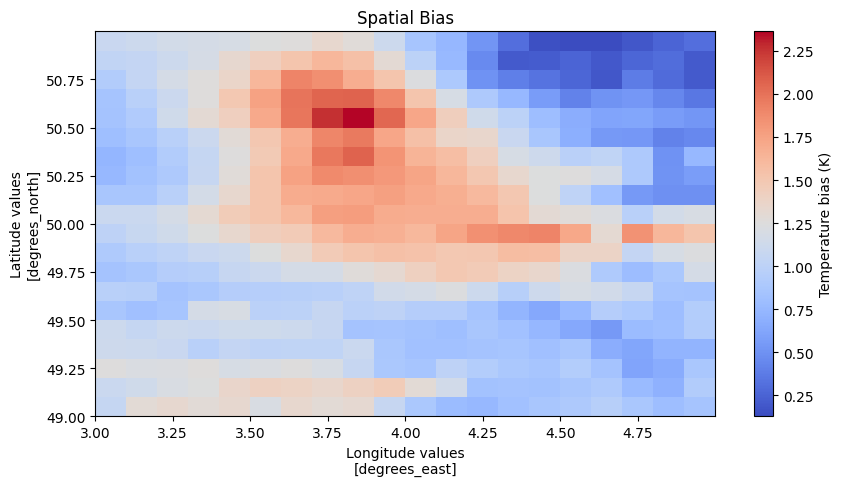

In [12]:
f = diag.visualize(dt.ensembles.cmip6.EC_Earth3.ssp245, dt.obs.EOBS)